In [17]:
import torch
from torchvision.transforms import ToTensor
from torchvision import datasets
import matplotlib.pyplot as plt

# 第一步：加载数据，使用torchvision中的常用数据集
training_data = datasets.MNIST(
    root='./Project1_data',
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root='./Project1_data',
    train=False,
    download=True,
    transform=ToTensor()
)


In [18]:
# 然后，我们来看一下长啥样（可视化）
img,lable = training_data[2]
img.shape

torch.Size([1, 28, 28])

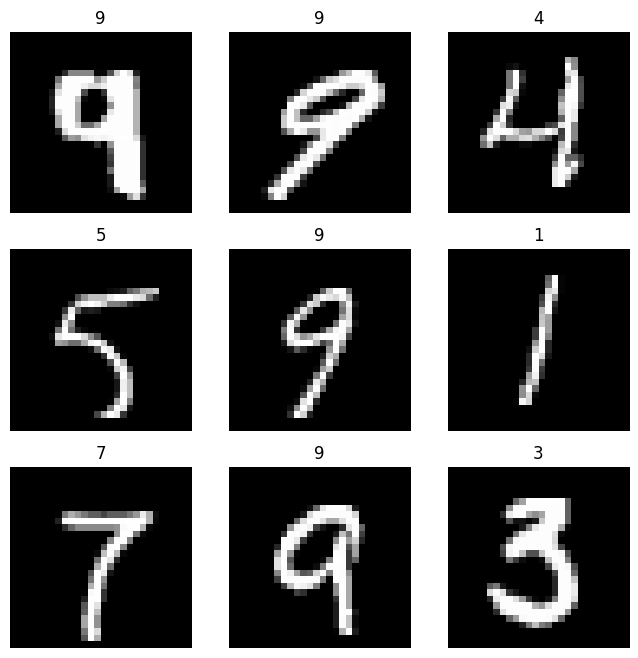

In [23]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [52]:
# 准备训练
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=100, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=100, shuffle=True)

# shuffle 决定是否打乱数据

In [53]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [119]:
import os
from torch import nn
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.seq = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
    def forward(self,x):
        x = self.flatten(x)
        return self.seq(x)

In [120]:
model = MyNet()
print(model)

MyNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (seq): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [121]:
loss_fn = nn.CrossEntropyLoss()

In [122]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [123]:
def train(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    # 设置模型状态为训练
    model.train()
    for batch,(X,y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred,y)
        # 计算梯度并累加
        loss.backward()
        #通过梯度更新参数（反向传播更新）
        optimizer.step()
        # 梯度清零！
        optimizer.zero_grad()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * 100 + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
def test(dataloader,model,loss_fn):
    # 设置模型状态为评估
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0,0

    # 禁用梯度计算，这样就不会构建计算图耗费资源
    with torch.no_grad():
        for X,y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred,y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

代码片段详解：计算正确预测数我们将这个表达式拆解成几个步骤来理解：$$(pred.\text{argmax}(1) == y).\text{type}(\text{torch.float}).\text{sum}().\text{item}()$$

步骤 1：获取预测结果pred.argmax(1)
- pred： 这是模型最后一层（例如，全连接层）的原始输出（Logits），通常形状是 (Batch_Size, C)，其中 $C$ 是类别数。
- .argmax(1)： 这是关键步骤。argmax 返回 Tensor 中最大值的索引。参数 1 表示沿着维度 1（即类别维度 $C$）进行操作。结果： 返回一个形状为 (Batch_Size) 的 Tensor，其中每个元素是模型预测的类别索引（例如，模型预测第 $i$ 个样本是类别 3，则该元素为 3）。

步骤 2：判断预测是否正确... == yy： 这是真实的标签（Labels），通常是一个形状为 (Batch_Size) 的 Tensor，其中每个元素是真实的类别索引。== 操作： 这是 PyTorch 中的逐元素比较操作。它将模型预测的类别索引 (来自 Step 1) 与真实的标签索引进行比较。结果： 返回一个形状为 (Batch_Size) 的 布尔（Boolean） Tensor。如果预测正确，元素值为 True。如果预测错误，元素值为 False。

步骤 3：转换为浮点数 Tensor... .type(torch.float).type(torch.float)： 将布尔 Tensor 转换为浮点数 Tensor。结果： True 被转换为浮点数 1.0，False 被转换为浮点数 0.0。目的： 这样做的目的是将“正确预测”的数量用 1.0 来表示，将“错误预测”用 0.0 来表示，方便下一步求和。

步骤 4：求和... .sum().sum()： 对上一步得到的 Tensor 进行求和。结果： 得到一个只有一个元素的 Tensor，其值是这个批次中所有 1.0（正确预测）的总和。这正是正确预测的数量。

步骤 5：提取数值... .item().item()： 将包含单个数值的 PyTorch Tensor 转换为标准的 Python 数值（Number）。最终结果： 得到一个 Python 整数或浮点数，表示当前批次中正确分类的样本总数。

In [124]:
num_epoches = 5
for i in range(num_epoches):
    train(train_dataloader, model, loss_fn, optimizer)

loss: 2.305258  [  100/60000]
loss: 0.170700  [10100/60000]
loss: 0.186304  [20100/60000]
loss: 0.083960  [30100/60000]
loss: 0.072678  [40100/60000]
loss: 0.099576  [50100/60000]
loss: 0.030145  [  100/60000]
loss: 0.029027  [10100/60000]
loss: 0.179811  [20100/60000]
loss: 0.118041  [30100/60000]
loss: 0.204692  [40100/60000]
loss: 0.082487  [50100/60000]
loss: 0.030273  [  100/60000]
loss: 0.049252  [10100/60000]
loss: 0.032844  [20100/60000]
loss: 0.046954  [30100/60000]
loss: 0.023566  [40100/60000]
loss: 0.047263  [50100/60000]
loss: 0.027146  [  100/60000]
loss: 0.070416  [10100/60000]
loss: 0.015619  [20100/60000]
loss: 0.100453  [30100/60000]
loss: 0.064178  [40100/60000]
loss: 0.012682  [50100/60000]
loss: 0.061365  [  100/60000]
loss: 0.069071  [10100/60000]
loss: 0.003593  [20100/60000]
loss: 0.010304  [30100/60000]
loss: 0.075045  [40100/60000]
loss: 0.030621  [50100/60000]


In [125]:
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.072163 

